<a href="https://colab.research.google.com/github/netaamz/DL-Model-for-Automated-Detection-of-Meniscus-Tears-in-Knee-MRI-Images/blob/main/learning_rate_3_planes_concatenate_DenseNet_transfer_learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

In [4]:
import warnings
warnings.filterwarnings("ignore")

#!pip install pyyaml

In [5]:

!pip install tensorflow
!pip install keras
!pip install h5py
!pip install sklearn
!pip install opencv-python
!pip install seaborn
!pip install matplotlib
!pip install numpy

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [6]:
# Import libraries here
import os
import tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from glob import glob
from IPython.display import Image, display
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score

import random as random
import imageio
import imgaug as ia
import tensorflow as tf
from tensorflow import keras
pd.options.mode.chained_assignment = None  # default='warn'


## Data import

**import data and get labels**

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The dataset contains *s* x 256 x 256 images. Since middle images are the most useful, only 3 middle slides in the series are retained.


## **data generation for meniscus**

In [8]:
def data_gen(dataset_type, plane, diagnosis):
    '''this function gets the data from the extracted datset'''
    # for eg, (train, sagittal, mensicus)
    if dataset_type == 'train':
        go = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transformf' # if we want without filter then:  /content/drive/My Drive/miniscus data set/MRNet-v1.0/train_transform
    else:
        go = '/content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transformf' # if we want without filter then: /content/drive/My Drive/miniscus data set/MRNet-v1.0/valid_transform

    plane_dir = f'{go}/{plane}.npy'

    data = np.load(plane_dir)
    label_path = f'/content/drive/My Drive/miniscus data set/MRNet-v1.0/{dataset_type}-{diagnosis}.csv'
#     label_path = f'data/{dataset_type}-{diagnosis}.csv'
    label_df = pd.read_csv(label_path, names=['nr', diagnosis])
    label_data = list(label_df[diagnosis])

    return(data, label_data)


In [9]:
# generate training input
coronal_mensicus, coronal_mensicus_label = data_gen('train', 'coronal/extracted_images', 'meniscus')
axial_mensicus, axial_mensicus_label = data_gen('train', 'axial/extracted_images', 'meniscus')
sagittal_mensicus, sagittal_mensicus_label = data_gen('train', 'sagittal/extracted_images', 'meniscus')
print(sagittal_mensicus.shape)
# generate validation
coronal_mensicus_val, coronal_mensicus_label_val  = data_gen('valid', 'coronal/extracted_images', 'meniscus')
axial_mensicus_val, axial_mensicus_label_val  = data_gen('valid', 'axial/extracted_images', 'meniscus')
sagittal_mensicus_val, sagittal_mensicus_label_val  = data_gen('valid', 'sagittal/extracted_images', 'meniscus')

(1130, 256, 256, 3)


In [10]:
from keras.utils import to_categorical  # Import to_categorical
base_path = "/content/drive/My Drive/miniscus data set/MRNet-v1.0/"

num_classes =2

sagittal_mensicus_label = to_categorical(sagittal_mensicus_label, num_classes)
sagittal_mensicus_label_val = to_categorical(sagittal_mensicus_label_val, num_classes)

coronal_mensicus_label = to_categorical(coronal_mensicus_label, num_classes)
coronal_mensicus_label_val = to_categorical(coronal_mensicus_label_val, num_classes)

axial_mensicus_label = to_categorical(axial_mensicus_label, num_classes)
axial_mensicus_label_val = to_categorical(axial_mensicus_label_val, num_classes)


In [11]:

from sklearn.metrics import log_loss
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

# Transfer Learning

##  Hyperparameters

In [12]:

    img_rows, img_cols = 256, 256  # Adjust based on your actual image dimensions
    channel = 3
    num_classes = 2  # Binary classification
    batch_size = 32
    nb_epoch= 100
    dropout = 0.4
    lr1 = 5e-3  # Learning rat
    lr2 = 5e-4  # Learning rat
    lr3 = 5e-5  # Learning rat

## Model Creation and training

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, BatchNormalization, Dropout, Concatenate, MaxPooling1D, Reshape, Flatten
from tensorflow.keras.optimizers import SGD, schedules
from tensorflow.keras.callbacks import ModelCheckpoint
def create_model2(input_shape, num_classes, dropout):
    # Base DenseNet model for each plane (axial, coronal, sagittal)
    base_model = DenseNet121(weights='imagenet', include_top=False, pooling=None, input_shape=input_shape)

    # Define input for each plane
    input_axial = Input(shape=input_shape, name='input_axial')
    input_coronal = Input(shape=input_shape, name='input_coronal')
    input_sagittal = Input(shape=input_shape, name='input_sagittal')

    # Process each plane using the same base DenseNet model
    axial_output = base_model(input_axial)
    coronal_output = base_model(input_coronal)
    sagittal_output = base_model(input_sagittal)

    # Global Average Pooling for each plane
    axial_output = GlobalAveragePooling2D()(axial_output)
    coronal_output = GlobalAveragePooling2D()(coronal_output)
    sagittal_output = GlobalAveragePooling2D()(sagittal_output)

    # Concatenate the outputs from all planes
    concatenated = Concatenate()([ axial_output, coronal_output, sagittal_output])

    # Dense and Dropout layers after concatenation
    x = BatchNormalization()(concatenated)
    x = Dropout(dropout)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(512, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=[input_axial, input_coronal, input_sagittal], outputs=output)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    return model


In [14]:
if __name__ == '__main__':
    input_shape = (img_rows, img_cols, channel)  # Update this with actual dimensions

    # Create the model with three inputs (for axial, coronal, and sagittal planes)
    model1 = create_model2(input_shape, num_classes, dropout)
    model2 = create_model2(input_shape, num_classes, dropout)
    model3 = create_model2(input_shape, num_classes, dropout)
    # Compile the model
    model1.compile(optimizer=SGD(learning_rate=lr1, momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model2.compile(optimizer=SGD(learning_rate=lr2, momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model3.compile(optimizer=SGD(learning_rate=lr3, momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Set up the checkpoint
    filepath = "bestmodel.keras"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    # Training run 1
    history1 = model1.fit([axial_mensicus, coronal_mensicus, sagittal_mensicus],
                         axial_mensicus_label,
                         batch_size=batch_size,
                         epochs=nb_epoch,
                         shuffle=True,
                         verbose=1,
                         validation_data=([axial_mensicus_val, coronal_mensicus_val, sagittal_mensicus_val], axial_mensicus_label_val),
                         callbacks=callbacks_list)

    # Training run 2
    history2 = model2.fit([axial_mensicus, coronal_mensicus, sagittal_mensicus],
                         axial_mensicus_label,
                         batch_size=batch_size,
                         epochs=nb_epoch,
                         shuffle=True,
                         verbose=1,
                         validation_data=([axial_mensicus_val, coronal_mensicus_val, sagittal_mensicus_val], axial_mensicus_label_val),
                         callbacks=callbacks_list)

    # Training run 3
    history3 = model3.fit([axial_mensicus, coronal_mensicus, sagittal_mensicus],
                         axial_mensicus_label,
                         batch_size=batch_size,
                         epochs=nb_epoch,
                         shuffle=True,
                         verbose=1,
                         validation_data=([axial_mensicus_val, coronal_mensicus_val, sagittal_mensicus_val], axial_mensicus_label_val),
                         callbacks=callbacks_list)



29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.5435 - loss: 0.8068
Epoch 1: val_accuracy improved from -inf to 0.56667, saving model to bestmodel.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.5444 - loss: 0.8060 - val_accuracy: 0.5667 - val_loss: 0.9122
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.6195 - loss: 0.6889
Epoch 2: val_accuracy did not improve from 0.56667
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 269ms/step - accuracy: 0.6198 - loss: 0.6886 - val_accuracy: 0.5667 - val_loss: 0.7892
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.6822 - loss: 0.6303
Epoch 3: val_accuracy did not improve from 0.56667
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step - accuracy: 0.6822 - loss: 0.6302 - val_accuracy: 0.5500 - val_loss: 0.7403
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.6868 - loss: 0.5911
Epoch 4: val_accuracy did not improve from 0.56667
36/36 ━━━━━

In [21]:
    # Evaluate the model
    predictions_valid1 = model1.predict([axial_mensicus_val, coronal_mensicus_val, sagittal_mensicus_val], batch_size=batch_size, verbose=1)
    score1 = log_loss(axial_mensicus_label_val, predictions_valid1)

    print(f"Log Loss learning rate-{lr1}: {score1}")





4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
Log Loss learning rate-0.005: 3.981200512326967


In [22]:
    predictions_valid2 = model2.predict([axial_mensicus_val, coronal_mensicus_val, sagittal_mensicus_val], batch_size=batch_size, verbose=1)
    score2 = log_loss(axial_mensicus_label_val, predictions_valid2)

    print(f"Log Loss learning rate-{lr2}: {score2}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step
Log Loss learning rate-0.0005: 1.8208790633892304


In [23]:

    predictions_valid3 = model3.predict([axial_mensicus_val, coronal_mensicus_val, sagittal_mensicus_val], batch_size=batch_size, verbose=1)
    score3 = log_loss(axial_mensicus_label_val, predictions_valid3)

    print(f"Log Loss learning rate-{lr3}: {score3}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
Log Loss learning rate-5e-05: 1.0148664706322854


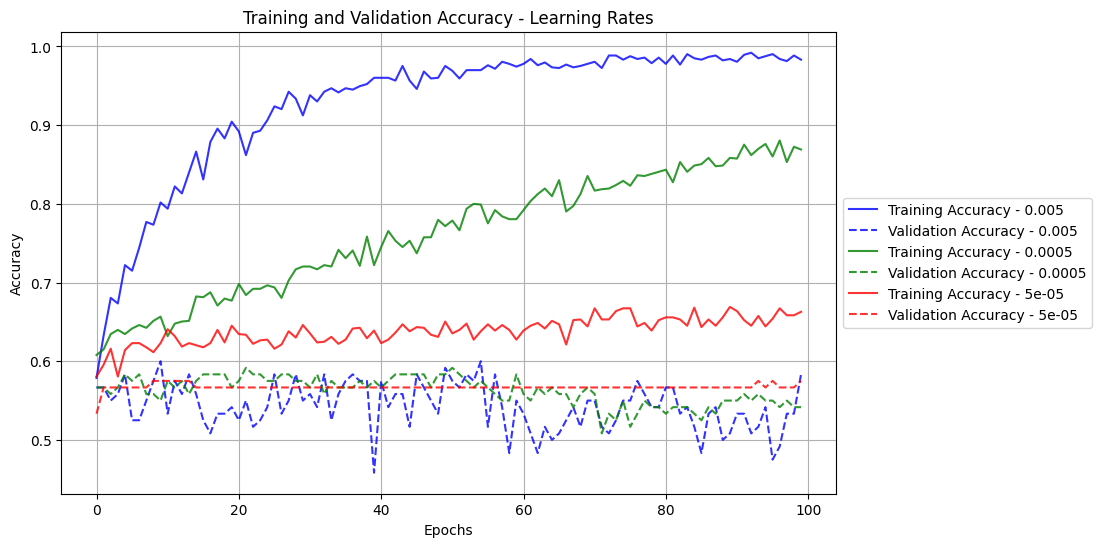

In [27]:
import matplotlib.pyplot as plt

# Assuming you have `history1`, `history2`, and `history3` from different training runs

# Data from first run
acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']


# Data from second run
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']


# Data from third run
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']
epochs=range(len(acc1)) #No. of epochs


# Set a wider figure size
plt.figure(figsize=(10, 6))  # Adjust width and height accordingly

# Plot training and validation accuracy for all runs
plt.plot(epochs, acc1, color='blue', label=f"Training Accuracy - {lr1}", alpha=0.8)
plt.plot(epochs, val_acc1, color='blue', linestyle='--', label=f'Validation Accuracy - {lr1}', alpha=0.8)

plt.plot(epochs, acc2, color='green', label=f'Training Accuracy - {lr2}', alpha=0.8)
plt.plot(epochs, val_acc2, color='green', linestyle='--', label=f'Validation Accuracy - {lr2}', alpha=0.8)

plt.plot(epochs, acc3, color='red', label=f'Training Accuracy - {lr3}', alpha=0.8)
plt.plot(epochs, val_acc3, color='red', linestyle='--', label=f'Validation Accuracy - {lr3}', alpha=0.8)

# Adjust title and labels
plt.title(f'Training and Validation Accuracy - Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add grid for better readability
plt.grid(True)


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(f'Train_val_acc_multiple_runs.png')
plt.show()

## Model evaluation

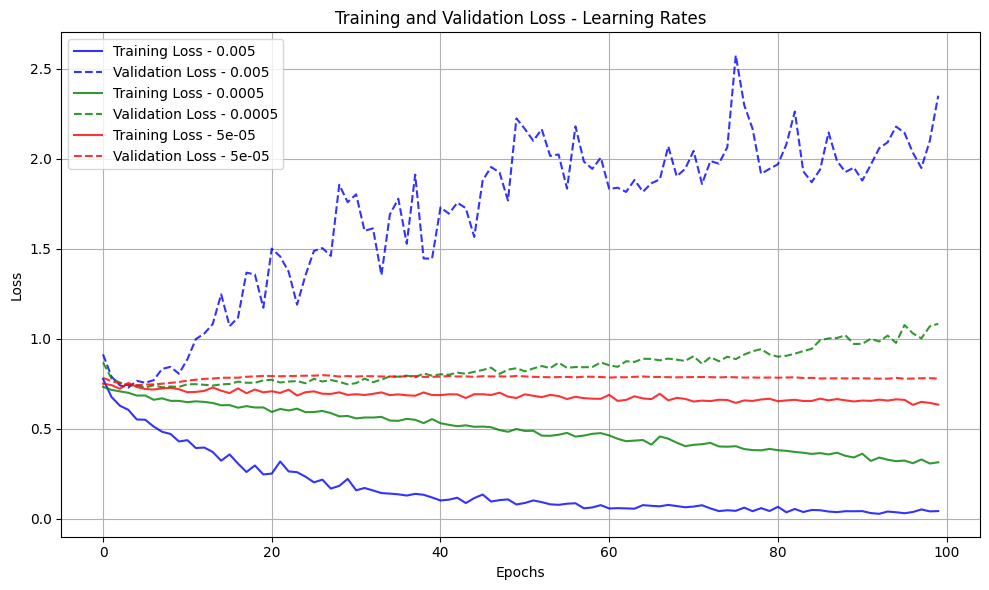

In [25]:
# Data from first run
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
# Data from second run
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

# Data from third run
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

plt.figure(figsize=(10, 6))


plt.plot(epochs, loss1, color='blue', label=f"Training Loss - {lr1}", alpha=0.8)
plt.plot(epochs, val_loss1, color='blue', linestyle='--', label=f'Validation Loss - {lr1}', alpha=0.8)

plt.plot(epochs, loss2, color='green', label=f'Training Loss - {lr2}', alpha=0.8)
plt.plot(epochs, val_loss2, color='green', linestyle='--', label=f'Validation Loss - {lr2}', alpha=0.8)

plt.plot(epochs, loss3, color='red', label=f'Training Loss - {lr3}', alpha=0.8)
plt.plot(epochs, val_loss3, color='red', linestyle='--', label=f'Validation Loss - {lr3}', alpha=0.8)

# Adjust title and labels
plt.title(f'Training and Validation Loss - Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Loss')


plt.grid(True)

# Position legend outside the plot (to the right)
plt.legend()

# Save and display the plot
plt.tight_layout()
plt.savefig(f'Train_val_loss_multiple_runs.png')
plt.show()

In [19]:
# Function to calculate accuracy and misclassification
def calculate_accuracy(ypred, ytest):
    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []

    for i in range(len(ypred)):
        if np.argmax(ypred[i]) == np.argmax(ytest[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)
        total += 1

    accuracy = round(accurate / total * 100, 3)
    return total, accurate, total - accurate, accuracy, accurateindex, wrongindex

In [26]:


total1, accurate1, wrong_1, accuracy_1, accurateindex_axial, wrongindex_axial = calculate_accuracy(predictions_valid1, axial_mensicus_label_val)
print(' - Total test data:', total1, '\tAccurately predicted data:', accurate1, '\tWrongly predicted data:', wrong_1)
print(f'{lr1} learning rate Accuracy:', accuracy_1, '%')


total2, accurate2, wrong_2, accuracy_2, accurateindex_axial, wrongindex_axial = calculate_accuracy(predictions_valid2, axial_mensicus_label_val)
print(' - Total test data:', total2, '\tAccurately predicted data:', accurate2, '\tWrongly predicted data:', wrong_2)
print(f'{lr2} learning rate Accuracy:', accuracy_2, '%')

total3, accurate3, wrong_3, accuracy_3, accurateindex_axial, wrongindex_axial = calculate_accuracy(predictions_valid3, axial_mensicus_label_val)
print(' - Total test data:', total3, '\tAccurately predicted data:', accurate3, '\tWrongly predicted data:', wrong_3)
print(f'{lr3} learning rate Accuracy:', accuracy_3, '%')

 - Total test data: 120 	Accurately predicted data: 70 	Wrongly predicted data: 50
0.005 learning rate Accuracy: 58.333 %
 - Total test data: 120 	Accurately predicted data: 65 	Wrongly predicted data: 55
0.0005 learning rate Accuracy: 54.167 %
 - Total test data: 120 	Accurately predicted data: 69 	Wrongly predicted data: 51
5e-05 learning rate Accuracy: 57.5 %
